•	EDA: Explore multicollinearity using variance inflation factors, pinpoint heteroscedasticity, and delineate variable relationships.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
branch_level_data = pd.read_csv('data/Branch_Level_Dataset.csv')
branch_level_data.head(5)

,EOM_TRANS_DATE,BranchCategory,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend
0,2022-01-31,Addition Financial Arena,0,3,0,28,5,20,6,4,14
1,2022-01-31,Altamonte Springs,98,394,64,469,1589,416,1642,646,3650
2,2022-01-31,Apopka,198,540,132,705,2219,560,1983,724,5731
3,2022-01-31,Boone High School,1,10,2,8,30,9,80,21,59
4,2022-01-31,Clermont,143,482,103,499,1940,539,1834,580,4551


In [3]:
# Remove rows where BranchCategory is 'High School' or 'Virtual Branch'
branch_level_data = branch_level_data[~branch_level_data['BranchCategory'].str.contains("High School|Virtual Branch|UCF Commons|Addition Financial Arena")]

# Check for null values in the DataFrame
null_values = branch_level_data.isnull().sum()

# Displaying the DataFrame and the null values information
print(branch_level_data.head())
print(null_values)


  EOM_TRANS_DATE     BranchCategory  ATM  Bill Payment  Cash  Draft   ACH  \
1     2022-01-31  Altamonte Springs   98           394    64    469  1589   
2     2022-01-31             Apopka  198           540   132    705  2219   
4     2022-01-31           Clermont  143           482   103    499  1940   
6     2022-01-31    Downtown Campus   27            35    12     62   134   
7     2022-01-31       East Orlando  165           701   106    836  3325   

   Fee  Credit/Debit Card  Home Banking  Dividend  
1  416               1642           646      3650  
2  560               1983           724      5731  
4  539               1834           580      4551  
6   78                227            47       275  
7  789               2993          1057      7938  
EOM_TRANS_DATE       0
BranchCategory       0
ATM                  0
Bill Payment         0
Cash                 0
Draft                0
ACH                  0
Fee                  0
Credit/Debit Card    0
Home Banking      

In [4]:
import pandas as pd

# Load the Excel file
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only the 'County' and 'TOTAL - All Revenue Account Codes' columns
# Assuming these are the first and the third-last columns in your DataFrame
df_revenue = df_revenue.iloc[:, [0, -3]]

# Renaming the columns for clarity
df_revenue.columns = ['County', 'Revenue_Per_County']

# Dropping the first row if it contains headers from the original table
df_revenue = df_revenue.drop(0)

# Displaying the modified DataFrame
print(df_revenue.head())



     County Revenue_Per_County
1   Alachua         1082349199
2     Baker           89157684
3       Bay         1193216378
4  Bradford           85933027
5   Brevard          958971976


In [5]:
import pandas as pd

# Map BranchCategory to County
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}

branch_level_data['County'] = branch_level_data['BranchCategory'].map(city_to_county_mapping)

# Load revenue data
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only 'County' and 'TOTAL - All Revenue Account Codes' columns
df_revenue = df_revenue.iloc[:, [0, -3]]
df_revenue.columns = ['County', 'Revenue_Per_County']
df_revenue = df_revenue.drop(0)

# Merging the DataFrames
branch_level_data = pd.merge(branch_level_data, df_revenue, on='County', how='left')

# Displaying the combined DataFrame
print(branch_level_data.head())


  EOM_TRANS_DATE     BranchCategory  ATM  Bill Payment  Cash  Draft   ACH  \
0     2022-01-31  Altamonte Springs   98           394    64    469  1589   
1     2022-01-31             Apopka  198           540   132    705  2219   
2     2022-01-31           Clermont  143           482   103    499  1940   
3     2022-01-31    Downtown Campus   27            35    12     62   134   
4     2022-01-31       East Orlando  165           701   106    836  3325   

   Fee  Credit/Debit Card  Home Banking  Dividend    County Revenue_Per_County  
0  416               1642           646      3650  Seminole         1830400546  
1  560               1983           724      5731    Orange         6968835122  
2  539               1834           580      4551      Lake         1003940427  
3   78                227            47       275    Orange         6968835122  
4  789               2993          1057      7938    Orange         6968835122  


            Variable        VIF
0                ATM  31.967666
1       Bill Payment   1.764924
2               Cash  14.576531
3              Draft  57.956488
4                ACH  23.411729
5                Fee  46.507688
6  Credit/Debit Card  32.471129
7       Home Banking  46.806628
8           Dividend  47.214718


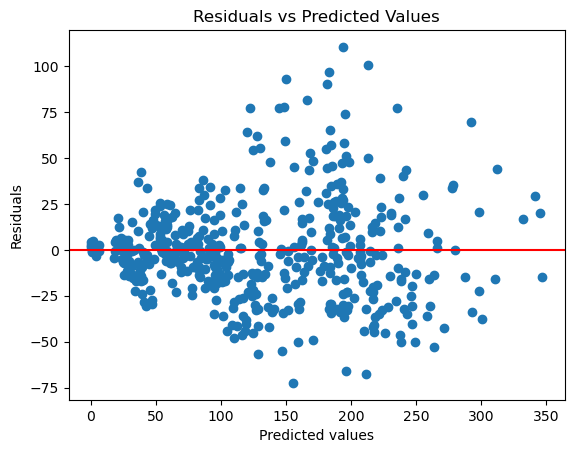

In [6]:
# Creating a copy of branch_level_data for VIF calculation
branch_level_data_copy = branch_level_data.copy()

# Dropping non-numeric columns for VIF calculation
features = branch_level_data_copy.drop(columns=['EOM_TRANS_DATE', 'BranchCategory', 'County', 'Revenue_Per_County'])

vif_data = pd.DataFrame()
vif_data["Variable"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
print(vif_data)

# Dropping a column from the copy for regression analysis
X = features.drop(columns=['ATM'])
y = branch_level_data_copy['ATM']
X = sm.add_constant(X)  # Adding a constant for the intercept

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
residuals = y - predictions

# Plotting Residuals vs Predicted Values
plt.scatter(predictions, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='-')  # Adding a horizontal line at y=0 for reference
plt.show()


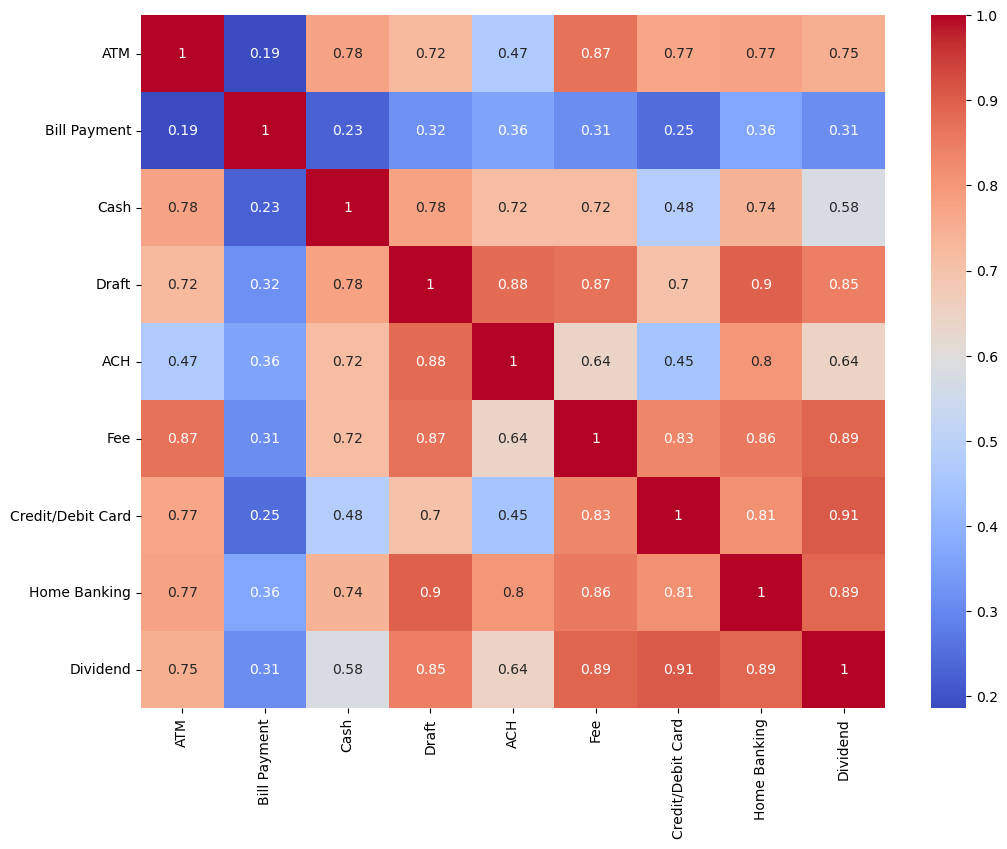

In [7]:
# Using a heatmap to visualize correlations
correlation_matrix = features.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


C:\Users\natet\AppData\Local\Temp\ipykernel_23184\649307579.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  branch_level_data_for_heatmap = branch_level_data_for_heatmap.groupby("BranchCategory").sum()


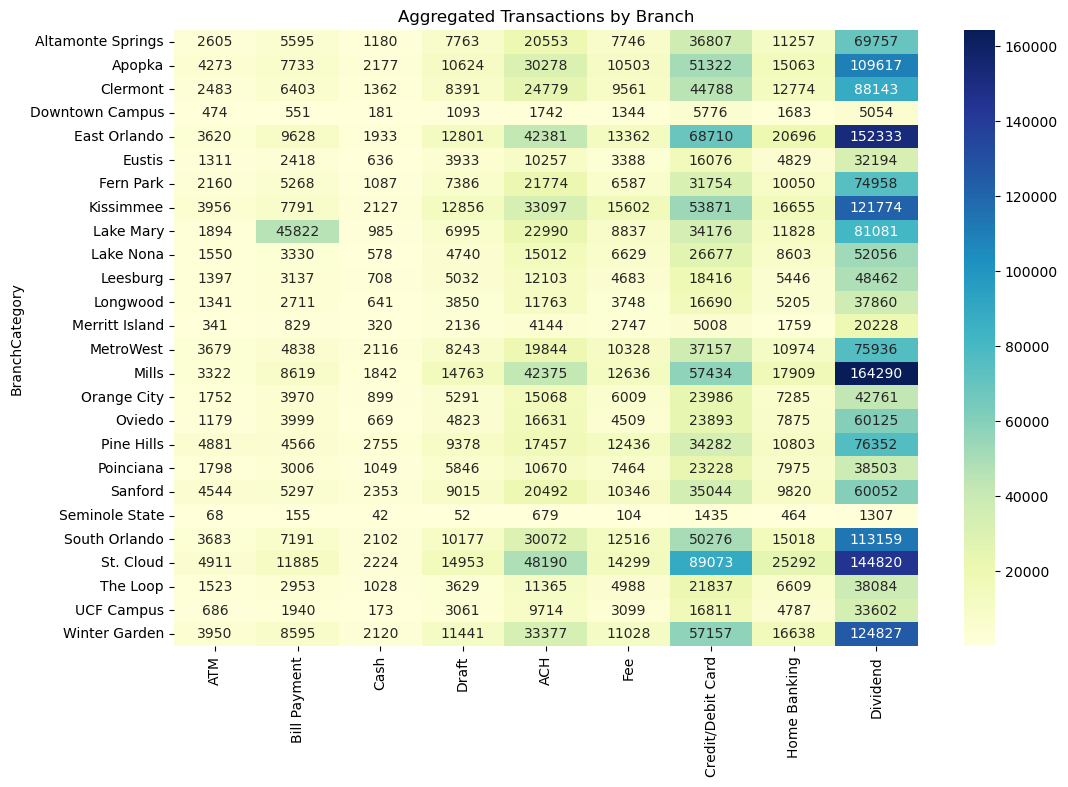

In [8]:
# Creating a separate copy for the heatmap visualization
branch_level_data_for_heatmap = branch_level_data.copy()

# Aggregating data by BranchCategory
branch_level_data_for_heatmap = branch_level_data_for_heatmap.groupby("BranchCategory").sum()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(branch_level_data_for_heatmap, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Aggregated Transactions by Branch")
plt.show()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Create a copy of the DataFrame to use for the analysis
branch_level_data_copy = branch_level_data.copy()

# Selecting features and target variable
# Drop non-feature columns and the target 'Revenue_Per_County' column
X = branch_level_data_copy.drop(columns=['Revenue_Per_County', 'EOM_TRANS_DATE', 'BranchCategory', 'County'])
y = branch_level_data_copy['Revenue_Per_County']

# Convert 'Revenue_Per_County' to numeric, in case it's not
y = pd.to_numeric(y, errors='coerce')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Coefficient of Determination (R^2):', r2_score(y_test, y_pred))

# Optionally, print the coefficients for each feature
feature_coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(feature_coefficients)



Mean Squared Error: 6.31973809787383e+18
Coefficient of Determination (R^2): 0.17238557367881435
                    Coefficient
ATM                9.823840e+06
Bill Payment      -6.186985e+05
Cash               1.014348e+07
Draft             -6.268392e+06
ACH                5.743753e+05
Fee               -9.672007e+05
Credit/Debit Card -1.153158e+06
Home Banking      -2.917264e+06
Dividend           1.430058e+06


In [10]:
branch_level_data

,EOM_TRANS_DATE,BranchCategory,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend,County,Revenue_Per_County
0,2022-01-31,Altamonte Springs,98,394,64,469,1589,416,1642,646,3650,Seminole,1830400546
1,2022-01-31,Apopka,198,540,132,705,2219,560,1983,724,5731,Orange,6968835122
2,2022-01-31,Clermont,143,482,103,499,1940,539,1834,580,4551,Lake,1003940427
3,2022-01-31,Downtown Campus,27,35,12,62,134,78,227,47,275,Orange,6968835122
4,2022-01-31,East Orlando,165,701,106,836,3325,789,2993,1057,7938,Orange,6968835122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,2023-07-31,South Orlando,158,396,130,615,2166,661,2600,752,6210,Orange,6968835122
490,2023-07-31,St. Cloud,208,623,145,846,3279,779,4750,1269,8096,Osceola,1592120547
491,2023-07-31,The Loop,66,155,68,210,871,287,1206,378,2218,Osceola,1592120547
492,2023-07-31,UCF Campus,30,92,11,153,715,192,839,250,1867,Orange,6968835122


In [11]:
unique_branch_categories = branch_level_data['BranchCategory'].unique()
number_of_unique_branch_categories = len(unique_branch_categories)

# Output the unique values
print("Unique Branch Categories:", unique_branch_categories)

# Output the number of unique values
print("Number of Unique Branch Categories:", number_of_unique_branch_categories)


Unique Branch Categories: ['Altamonte Springs' 'Apopka' 'Clermont' 'Downtown Campus' 'East Orlando'
 'Eustis' 'Fern Park' 'Kissimmee' 'Lake Mary' 'Lake Nona' 'Leesburg'
 'Longwood' 'Merritt Island' 'MetroWest' 'Mills' 'Orange City' 'Oviedo'
 'Pine Hills' 'Poinciana' 'Sanford' 'Seminole State' 'South Orlando'
 'St. Cloud' 'The Loop' 'UCF Campus' 'Winter Garden']
Number of Unique Branch Categories: 26


In [12]:
branch_count = branch_level_data.groupby('County')['BranchCategory'].nunique()
branch_count.name = 'Branch_Count'

# Aggregate the transaction data by the 'County' column, summing up all the transaction-related columns
county_transactions_agg = branch_level_data.groupby('County').agg({
    'ATM': 'sum',
    'Bill Payment': 'sum',
    'Cash': 'sum',
    'Draft': 'sum',
    'ACH': 'sum',
    'Fee': 'sum',
    'Credit/Debit Card': 'sum',
    'Home Banking': 'sum',
    'Dividend': 'sum'
}).reset_index()

# Calculate the total transactions per county
county_transactions_agg['Total_Transactions'] = county_transactions_agg.drop('County', axis=1).sum(axis=1)

# Calculate the average transactions per branch for each county
county_transactions_agg = county_transactions_agg.merge(branch_count.reset_index(), on='County')
county_transactions_agg['Average_Transactions_Per_Branch'] = county_transactions_agg['Total_Transactions'] / county_transactions_agg['Branch_Count']

# Display the DataFrame with total and average transactions
county_transactions_agg[['County', 'Total_Transactions', 'Branch_Count', 'Average_Transactions_Per_Branch']]



,County,Total_Transactions,Branch_Count,Average_Transactions_Per_Branch
0,Brevard,37512,1,37512.0
1,Lake,373110,3,124370.0
2,Orange,1960542,10,196054.2
3,Osceola,715392,3,238464.0
4,Polk,99539,1,99539.0
5,Seminole,907676,7,129668.0
6,Volusia,107021,1,107021.0


     County  Total_Transactions  Branch_Count  Average_Transactions_Per_Branch
3   Osceola              715392             3                         238464.0
2    Orange             1960542            10                         196054.2
5  Seminole              907676             7                         129668.0
1      Lake              373110             3                         124370.0
6   Volusia              107021             1                         107021.0
4      Polk               99539             1                          99539.0
0   Brevard               37512             1                          37512.0


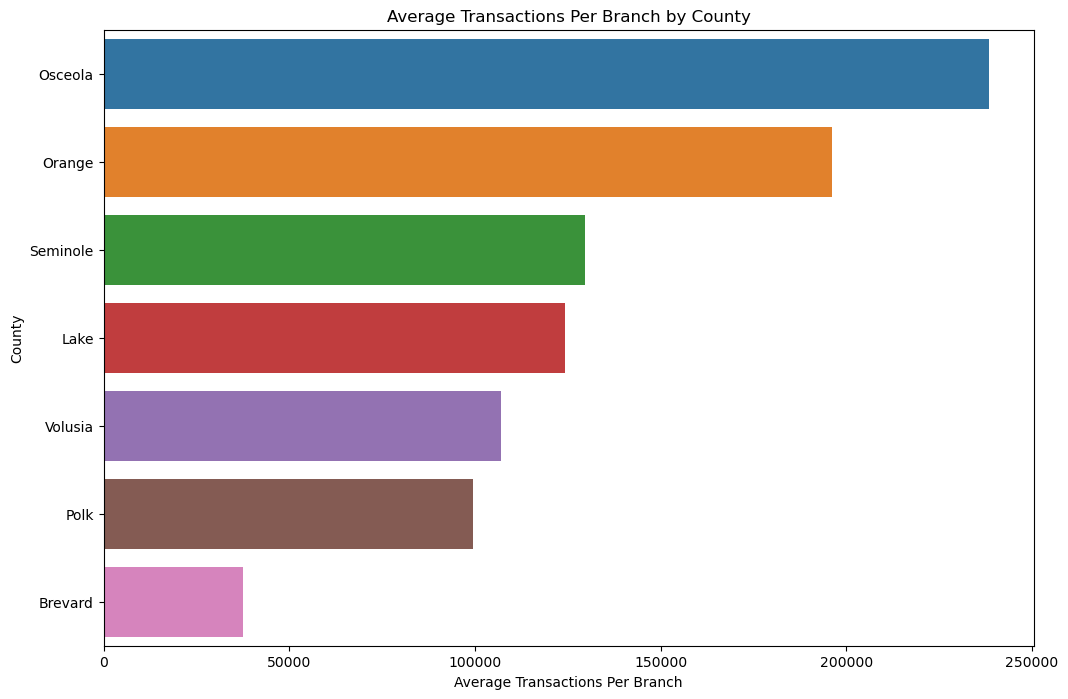

In [13]:
# Sorting counties by the average transactions per branch
county_transactions_agg_sorted = county_transactions_agg.sort_values(by='Average_Transactions_Per_Branch', ascending=False)

# Displaying the counties with their average transaction data per branch
print(county_transactions_agg_sorted[['County', 'Total_Transactions', 'Branch_Count', 'Average_Transactions_Per_Branch']])

# Visualization - Average Transactions per Branch by County
plt.figure(figsize=(12, 8))
sns.barplot(y=county_transactions_agg_sorted['County'], x=county_transactions_agg_sorted['Average_Transactions_Per_Branch'])
plt.title('Average Transactions Per Branch by County')
plt.ylabel('County')
plt.xlabel('Average Transactions Per Branch')
plt.show()


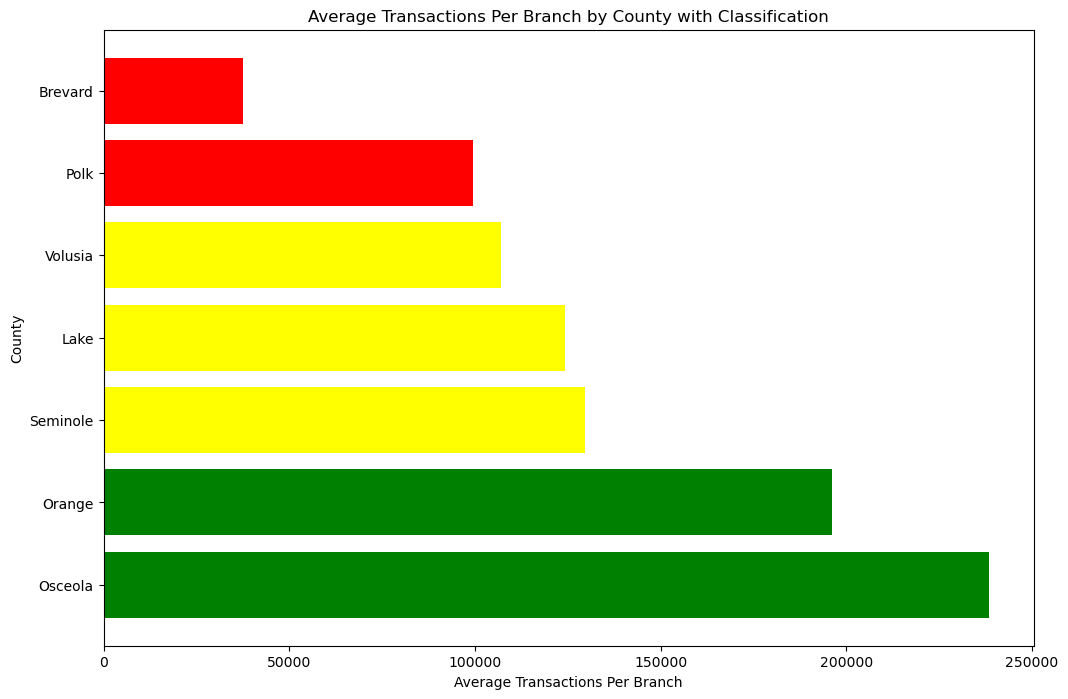

In [14]:
# Define classification thresholds
high_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.75) # top 25%
medium_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.25) # bottom 25%

# Classify counties
county_transactions_agg_sorted['Classification'] = 'Low'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= medium_threshold, 'Classification'] = 'Medium'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= high_threshold, 'Classification'] = 'High'

# Visualize the classified data
colors = {'Low': 'red', 'Medium': 'yellow', 'High': 'green'}
plt.figure(figsize=(12, 8))
plt.barh(county_transactions_agg_sorted['County'], county_transactions_agg_sorted['Average_Transactions_Per_Branch'], color=[colors[cls] for cls in county_transactions_agg_sorted['Classification']])
plt.title('Average Transactions Per Branch by County with Classification')
plt.xlabel('Average Transactions Per Branch')
plt.ylabel('County')
plt.show()


In [15]:
import requests

def get_coordinates(county_name):
    county_name_formatted = county_name.replace(' ', '+') + ',+Florida'
    url = f"https://nominatim.openstreetmap.org/search?q={county_name_formatted}&format=json"
    response = requests.get(url)
    data = response.json()
    latitude = data[0]['lat']
    longitude = data[0]['lon']
    return latitude, longitude

# List of counties
counties = ['Orange', 'Seminole', 'Lake', 'Osceola', 'Brevard', 'Volusia', 'Polk']

# Fetching and printing coordinates for each county
for county in counties:
    latitude, longitude = get_coordinates(county + ' County')
    print(f"The coordinates for {county} County are Latitude: {latitude} and Longitude: {longitude}")



The coordinates for Orange County are Latitude: 28.5421109 and Longitude: -81.3790304
The coordinates for Seminole County are Latitude: 28.7225829 and Longitude: -81.2353683
The coordinates for Lake County are Latitude: 28.7006859 and Longitude: -81.78994
The coordinates for Osceola County are Latitude: 28.0443842 and Longitude: -81.1437541
The coordinates for Brevard County are Latitude: 28.2100203 and Longitude: -80.7997185
The coordinates for Volusia County are Latitude: 29.0533409 and Longitude: -81.1310761
The coordinates for Polk County are Latitude: 27.9448537 and Longitude: -81.7268789


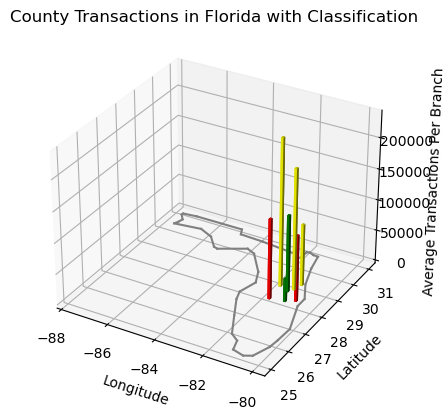

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

states = gpd.read_file('Florida_shape/ne_110m_admin_1_states_provinces.shp')
florida = states[states['name'] == 'Florida']
florida_boundary = florida.geometry.values[0].exterior.coords.xy
florida_x = list(florida_boundary[0])
florida_y = list(florida_boundary[1])

County_Coordinates = {
    'Osceola': (28.0443842, -81.1437541),
    'Orange': (28.5421109, -81.3790304),
    'Seminole': (28.7225829, -81.2353683),
    'Lake': (28.7006859, -81.78994),
    'Volusia': (29.0533409, -81.1310761),
    'Polk': (27.9448537, -81.7268789),
    'Brevard': (28.2100203, -80.7997185)
}

# Define classification thresholds and colors
high_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.75)
medium_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.25)
county_transactions_agg_sorted['Classification'] = 'Low'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= medium_threshold, 'Classification'] = 'Medium'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= high_threshold, 'Classification'] = 'High'
colors = {'Low': 'red', 'Medium': 'yellow', 'High': 'green'}

# Extract x, y, z data for counties
x = [County_Coordinates[county][1] for county in county_transactions_agg_sorted['County']]  # longitude
y = [County_Coordinates[county][0] for county in county_transactions_agg_sorted['County']]  # latitude
z = county_transactions_agg_sorted['Average_Transactions_Per_Branch']
color_map = [colors[cls] for cls in county_transactions_agg_sorted['Classification']]

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the shape of Florida
for i in range(len(florida_x) - 1):
    ax.plot([florida_x[i], florida_x[i+1]], 
            [florida_y[i], florida_y[i+1]], 
            [0, 0], color='gray')

# Plot each county's data as a colored pillar
for i in range(len(x)):
    ax.bar3d(x[i], y[i], 0, 0.1, 0.1, z[i], color=color_map[i], shade=True)

# Labeling and titles
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Average Transactions Per Branch')
ax.set_title('County Transactions in Florida with Classification')

plt.show()



In [17]:
county_transactions_agg_sorted

,County,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend,Total_Transactions,Branch_Count,Average_Transactions_Per_Branch,Classification
3,Osceola,10390,22629,5379,31438,92652,34889,164781,48556,304678,715392,3,238464.0,High
2,Orange,30118,56991,15977,86321,242252,93881,405602,122174,907226,1960542,10,196054.2,High
5,Seminole,13791,68847,6957,39884,114882,41877,179799,56499,385140,907676,7,129668.0,Medium
1,Lake,5191,11958,2706,17356,47139,17632,79280,23049,168799,373110,3,124370.0,Medium
6,Volusia,1752,3970,899,5291,15068,6009,23986,7285,42761,107021,1,107021.0,Medium
4,Polk,1798,3006,1049,5846,10670,7464,23228,7975,38503,99539,1,99539.0,Low
0,Brevard,341,829,320,2136,4144,2747,5008,1759,20228,37512,1,37512.0,Low


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

population_data = pd.read_csv('data/Population_Data.csv')

# Correct the column name after loading the data
population_data.rename(columns={'name': 'County'}, inplace=True)

# Remove the word "County" from the 'County' column to match county_transactions_agg_sorted
population_data['County'] = population_data['County'].str.replace(' County', '')


# Correct the column name after loading the data
population_data.rename(columns={'name': 'County'}, inplace=True)

# Filter for the counties of interest and calculate the average population
counties_of_interest = ['Orange', 'Seminole', 'Lake', 'Osceola', 'Brevard', 'Volusia', 'Polk']
population_data = population_data[population_data['County'].isin(counties_of_interest)]
population_data['Average_Population'] = population_data.loc[:, 'pop2010':'pop2023'].mean(axis=1)

# Merge this average population data with your transactions data
county_transactions_agg_sorted = county_transactions_agg_sorted.merge(
    population_data[['County', 'Average_Population']],
    on='County'
)

# Calculate the average transactions per capita
county_transactions_agg_sorted['Transactions_Per_Capita'] = (
    county_transactions_agg_sorted['Average_Transactions_Per_Branch'] /
    county_transactions_agg_sorted['Average_Population']
)

Osceola: Classification - High, Transactions Per Capita - 0.6878782459197037
Orange: Classification - High, Transactions Per Capita - 0.14735106343400667
Seminole: Classification - Medium, Transactions Per Capita - 0.2856073020739723
Lake: Classification - Medium, Transactions Per Capita - 0.3517858001521756
Volusia: Classification - Medium, Transactions Per Capita - 0.20082359045280587
Polk: Classification - Low, Transactions Per Capita - 0.14594883088738778
Brevard: Classification - Low, Transactions Per Capita - 0.06418012592389817


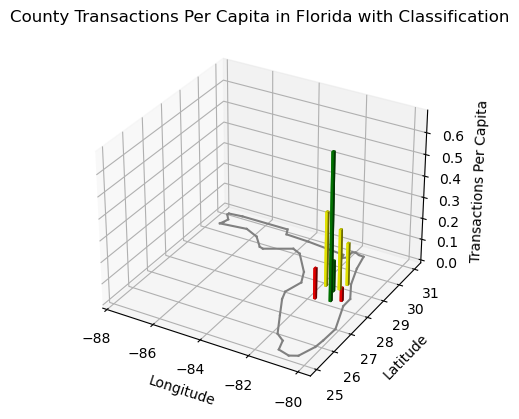

In [19]:
# Print classifications and transactions per capita for each county
for index, row in county_transactions_agg_sorted.iterrows():
    print(f"{row['County']}: Classification - {row['Classification']}, "
          f"Transactions Per Capita - {row['Transactions_Per_Capita']}")

z = county_transactions_agg_sorted['Transactions_Per_Capita']

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the shape of Florida
for i in range(len(florida_x) - 1):
    ax.plot([florida_x[i], florida_x[i+1]], [florida_y[i], florida_y[i+1]], [0, 0], color='gray')

# Plot each county's average transactions per capita as a colored pillar
for i in range(len(x)):
    ax.bar3d(x[i], y[i], 0, 0.1, 0.1, z[i], color=color_map[i], shade=True)

# Labeling and titles
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions Per Capita')
ax.set_title('County Transactions Per Capita in Florida with Classification')

plt.show()


In [20]:
county_transactions_agg_sorted

,County,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend,Total_Transactions,Branch_Count,Average_Transactions_Per_Branch,Classification,Average_Population,Transactions_Per_Capita
0,Osceola,10390,22629,5379,31438,92652,34889,164781,48556,304678,715392,3,238464.0,High,346666.0,0.687878
1,Orange,30118,56991,15977,86321,242252,93881,405602,122174,907226,1960542,10,196054.2,High,1330524.5,0.147351
2,Seminole,13791,68847,6957,39884,114882,41877,179799,56499,385140,907676,7,129668.0,Medium,454008.0,0.285607
3,Lake,5191,11958,2706,17356,47139,17632,79280,23049,168799,373110,3,124370.0,Medium,353539.0,0.351786
4,Volusia,1752,3970,899,5291,15068,6009,23986,7285,42761,107021,1,107021.0,Medium,532910.5,0.200824
5,Polk,1798,3006,1049,5846,10670,7464,23228,7975,38503,99539,1,99539.0,Low,682013.0,0.145949
6,Brevard,341,829,320,2136,4144,2747,5008,1759,20228,37512,1,37512.0,Low,584480.0,0.064180


In [21]:
import requests

def get_coordinates(address):
    try:
        address_formatted = address.replace(' ', '+') + ',+Florida'
        url = f"https://nominatim.openstreetmap.org/search?q={address_formatted}&format=json"
        response = requests.get(url)
        data = response.json()
        if not data:
            return 'No data', 'No data'
        latitude = data[0]['lat']
        longitude = data[0]['lon']
        return latitude, longitude
    except Exception as e:
        return f'Error: {e}', f'Error: {e}'
    
    # List of all 27 branch addresses
branch_addresses = [
    '1000 Primera Blvd, Lake Mary, FL 32746',  # Lake Mary Branch
    '847 S Orange Blossom Trail, Apopka, FL 32703',  # Apopka Branch
    '1948 W County Road 419, Chuluota, FL 32766',  # Oviedo Branch
    '2390 E Highway 50, Clermont, FL 34711',  # Clermont Branch
    '15830 US Highway 441, Eustis, FL 32726',  # Eustis Branch
    '215 Oxford Rd, Fern Park, FL 32730',  # Fern Park Branch
    '855 S State Road 434, Forest City, FL 32714',  # Altamonte Springs Branch
    '708 E Vine St, Kissimmee, FL 34744',  # Kissimmee Branch
    '3070 N Orange Blossom Trail, Kissimmee, FL 34741',  # The Loop Branch
    '4620 Pleasant Hill Rd, Kissimmee, FL 34759',  # Poinciana Branch
    '8040 US Highway 441, Leesburg, FL 34788',  # Leesburg Branch
    '901 E State Road 434, Longwood, FL 32750',  # Longwood Branch
    '1380 N Courtenay Pkwy, Merritt Island, FL 32953',  # Merritt Island Branch
    '920 Saxon Blvd, Orange City, FL 32763',  # Orange City Branch
    '13810 Narcoossee Rd, Orlando, FL 32832',  # Lake Nona Branch
    '12795 Aquaris Agora Dr, Orlando, FL 32816',  # UCF Campus Branch
    '5301 S Orange Ave, Orlando, FL 32809',  # South Orlando Branch
    '947 N Mills Ave, Orlando, FL 32803',  # Mills Branch
    '5990 MetroWest Blvd, Orlando, FL 32835',  # Metro West Branch
    '4601 Silver Star Rd, Orlando, FL 32808',  # Pine Hills Branch
    '101 E 25th St, Sanford, FL 32771',  # Sanford Branch
    '101 E 25th St, Sanford, FL 32771',  # Seminole State Branch
    '3335 13th St, Saint Cloud, FL 34769',  # St. Cloud Branch
    '950 9th St, Winter Garden, FL 34787',  # Winter Garden Branch
    '617 W Livingston St, Orlando, FL 32801',  # Downtown Campus Branch
    '1823 N Alafaya Trail, Orlando, FL 32826',  # East Orlando Branch
]

# List to store results
results = []

# Fetching coordinates for each branch
for address in branch_addresses:
    latitude, longitude = get_coordinates(address)
    results.append({'Address': address, 'Latitude': latitude, 'Longitude': longitude})

# Convert the list to a DataFrame
df_coordinates = pd.DataFrame(results)

# Display the DataFrame
print(df_coordinates)

# Print addresses with 'No data' coordinates
print("Addresses without coordinates:")
print(df_coordinates[df_coordinates['Latitude'] == 'No data']['Address'])



                                             Address           Latitude  \
0             1000 Primera Blvd, Lake Mary, FL 32746  28.76514713597197   
1       847 S Orange Blossom Trail, Apopka, FL 32703         28.6688026   
2         1948 W County Road 419, Chuluota, FL 32766            No data   
3              2390 E Highway 50, Clermont, FL 34711         28.5473196   
4             15830 US Highway 441, Eustis, FL 32726         28.8224177   
5                 215 Oxford Rd, Fern Park, FL 32730            No data   
6        855 S State Road 434, Forest City, FL 32714            No data   
7                 708 E Vine St, Kissimmee, FL 34744          28.304381   
8   3070 N Orange Blossom Trail, Kissimmee, FL 34741         28.3219603   
9         4620 Pleasant Hill Rd, Kissimmee, FL 34759            No data   
10           8040 US Highway 441, Leesburg, FL 34788         28.8218183   
11          901 E State Road 434, Longwood, FL 32750            No data   
12   1380 N Courtenay Pkw

1948 W County Road 419, Chuluota, FL 32766, Lat: 28.655315, Long: -81.169944

215 Oxford Rd, Fern Park, FL 32730, Lat: 28.655927,  Long: -81.339953

855 S State Road 434, Forest City, FL 32714, Lat: 28.665416 , Long: -81.419095

4620 Pleasant Hill Rd, Kissimmee, FL 34759, Lat: 28.085617 , Long: -81.517654

901 E State Road 434, Longwood, FL 32750, Lat: 28.697926 , Long: -81.330179

12795 Aquaris Agora Dr, Orlando, FL 32816, Lat: 28.603338, Long: -81.20376

947 N Mills Ave, Orlando, FL 32803, Lat: 28.55761 , Long: -81.364377

617 W Livingston St, Orlando, FL 32801, Lat: 28.547566 , Long: -81.372652

1823 N Alafaya Trail, Orlando, FL 32826, Lat: 28.569098, Long: -81.207569

In [22]:
# Dictionary of addresses with manual coordinates
manual_coordinates = {
    '1948 W County Road 419, Chuluota, FL 32766': (28.655315, -81.169944),
    '215 Oxford Rd, Fern Park, FL 32730': (28.655927, -81.339953),
    '855 S State Road 434, Forest City, FL 32714': (28.665416, -81.419095),
    '4620 Pleasant Hill Rd, Kissimmee, FL 34759': (28.085617, -81.517654),
    '901 E State Road 434, Longwood, FL 32750': (28.697926, -81.330179),
    '12795 Aquaris Agora Dr, Orlando, FL 32816': (28.603338, -81.20376),
    '947 N Mills Ave, Orlando, FL 32803': (28.55761, -81.364377),
    '617 W Livingston St, Orlando, FL 32801': (28.547566, -81.372652),
    '1823 N Alafaya Trail, Orlando, FL 32826': (28.569098, -81.207569)
}

# Update DataFrame
for index, row in df_coordinates.iterrows():
    if row['Latitude'] == 'No data' and row['Address'] in manual_coordinates:
        lat, long = manual_coordinates[row['Address']]
        df_coordinates.at[index, 'Latitude'] = lat
        df_coordinates.at[index, 'Longitude'] = long

# Display the updated DataFrame
print(df_coordinates)


                                             Address           Latitude  \
0             1000 Primera Blvd, Lake Mary, FL 32746  28.76514713597197   
1       847 S Orange Blossom Trail, Apopka, FL 32703         28.6688026   
2         1948 W County Road 419, Chuluota, FL 32766          28.655315   
3              2390 E Highway 50, Clermont, FL 34711         28.5473196   
4             15830 US Highway 441, Eustis, FL 32726         28.8224177   
5                 215 Oxford Rd, Fern Park, FL 32730          28.655927   
6        855 S State Road 434, Forest City, FL 32714          28.665416   
7                 708 E Vine St, Kissimmee, FL 34744          28.304381   
8   3070 N Orange Blossom Trail, Kissimmee, FL 34741         28.3219603   
9         4620 Pleasant Hill Rd, Kissimmee, FL 34759          28.085617   
10           8040 US Highway 441, Leesburg, FL 34788         28.8218183   
11          901 E State Road 434, Longwood, FL 32750          28.697926   
12   1380 N Courtenay Pkw

In [23]:
import pandas as pd

# Sum the transaction-related columns to get the total transactions for each branch
branch_level_data['Total_Transactions'] = branch_level_data[['ATM', 'Bill Payment', 'Cash', 'Draft', 'ACH', 'Fee', 'Credit/Debit Card', 'Home Banking', 'Dividend']].sum(axis=1)

# Now, group by 'BranchCategory' and sum up the 'Total_Transactions' to get the total per city
transactions_per_city = branch_level_data.groupby('BranchCategory')['Total_Transactions'].sum().reset_index()

# Display the result
print(transactions_per_city)


       BranchCategory  Total_Transactions
0   Altamonte Springs              163263
1              Apopka              241590
2            Clermont              198684
3     Downtown Campus               17898
4        East Orlando              325464
5              Eustis               75042
6           Fern Park              161024
7           Kissimmee              267729
8           Lake Mary              214608
9           Lake Nona              119175
10           Leesburg               99384
11           Longwood               83809
12     Merritt Island               37512
13          MetroWest              173115
14              Mills              323190
15        Orange City              107021
16             Oviedo              123703
17         Pine Hills              172910
18          Poinciana               99539
19            Sanford              156963
20     Seminole State                4306
21      South Orlando              244194
22          St. Cloud             

In [24]:
import pandas as pd

# Sum the transaction-related columns to get the total transactions for each branch
branch_level_data['Total_Transactions'] = branch_level_data[['ATM', 'Bill Payment', 'Cash', 'Draft', 'ACH', 'Fee', 'Credit/Debit Card', 'Home Banking', 'Dividend']].sum(axis=1)

# Group by 'BranchCategory' and sum up the 'Total_Transactions' to get the total per city
transactions_per_city = branch_level_data.groupby('BranchCategory')['Total_Transactions'].sum().reset_index()

# Manual mapping of BranchCategory to address
branch_to_address = {
    'Altamonte Springs': '855 S State Road 434, Forest City, FL 32714',
    'Apopka': '847 S Orange Blossom Trail, Apopka, FL 32703',
    'Clermont': '2390 E Highway 50, Clermont, FL 34711',
    'Downtown Campus': '617 W Livingston St, Orlando, FL 32801',
    'East Orlando': '1823 N Alafaya Trail, Orlando, FL 32826',
    'Eustis': '15830 US Highway 441, Eustis, FL 32726',
    'Fern Park': '215 Oxford Rd, Fern Park, FL 32730',
    'Kissimmee': '708 E Vine St, Kissimmee, FL 34744',
    'Lake Mary': '1000 Primera Blvd, Lake Mary, FL 32746',
    'Lake Nona': '13810 Narcoossee Rd, Orlando, FL 32832',
    'Leesburg': '8040 US Highway 441, Leesburg, FL 34788',
    'Longwood': '901 E State Road 434, Longwood, FL 32750',
    'Merritt Island': '1380 N Courtenay Pkwy, Merritt Island, FL 32953',
    'MetroWest': '5990 MetroWest Blvd, Orlando, FL 32835',
    'Mills': '947 N Mills Ave, Orlando, FL 32803',
    'Orange City': '920 Saxon Blvd, Orange City, FL 32763',
    'Oviedo': '1948 W County Road 419, Chuluota, FL 32766',
    'Pine Hills': '4601 Silver Star Rd, Orlando, FL 32808',
    'Poinciana': '4620 Pleasant Hill Rd, Kissimmee, FL 34759',
    'Sanford': '101 E 25th St, Sanford, FL 32771',
    'Seminole State': '101 E 25th St, Sanford, FL 32771',
    'South Orlando': '5301 S Orange Ave, Orlando, FL 32809',
    'St. Cloud': '3335 13th St, Saint Cloud, FL 34769',
    'The Loop': '3070 N Orange Blossom Trail, Kissimmee, FL 34741',
    'UCF Campus': '12795 Aquaris Agora Dr, Orlando, FL 32816',
    'Winter Garden': '950 9th St, Winter Garden, FL 34787'
}


# Creating a DataFrame from the mapping
address_df = pd.DataFrame(list(branch_to_address.items()), columns=['BranchCategory', 'Address'])

# Merge the transactions DataFrame with the address DataFrame
transactions_with_address = transactions_per_city.merge(address_df, on='BranchCategory', how='left')

# Merge the transactions with address DataFrame with the coordinates DataFrame
final_df = transactions_with_address.merge(df_coordinates, on='Address', how='left')

# Print the final DataFrame with transactions, addresses, and coordinates
print(final_df)


       BranchCategory  Total_Transactions  \
0   Altamonte Springs              163263   
1              Apopka              241590   
2            Clermont              198684   
3     Downtown Campus               17898   
4        East Orlando              325464   
5              Eustis               75042   
6           Fern Park              161024   
7           Kissimmee              267729   
8           Lake Mary              214608   
9           Lake Nona              119175   
10           Leesburg               99384   
11           Longwood               83809   
12     Merritt Island               37512   
13          MetroWest              173115   
14              Mills              323190   
15        Orange City              107021   
16             Oviedo              123703   
17         Pine Hills              172910   
18          Poinciana               99539   
19            Sanford              156963   
20            Sanford              156963   
21     Sem

In [25]:
branch_to_city_map = {
    'Downtown Campus': 'Orlando',
    'East Orlando': 'Orlando',
    'MetroWest': 'Orlando',
    'Lake Nona': 'Orlando',
    'Mills': 'Orlando',
    'Pine Hills': 'Orlando',
    'The Loop': 'Kissimmee',
    'UCF Campus': 'Orlando',
    'Fern Park': 'Casselberry',
    'Merritt Island': 'Cape Canaveral',
    'Poinciana': 'Kissimmee',
    'Seminole State': 'Sanford',
    'South Orlando' :'Orlando'
}

# Update BranchCategory in final_df
for index, row in final_df.iterrows():
    if row['BranchCategory'] in branch_to_city_map:
        final_df.at[index, 'BranchCategory'] = branch_to_city_map[row['BranchCategory']]

# Now final_df will have updated BranchCategory names
print(final_df)



       BranchCategory  Total_Transactions  \
0   Altamonte Springs              163263   
1              Apopka              241590   
2            Clermont              198684   
3             Orlando               17898   
4             Orlando              325464   
5              Eustis               75042   
6         Casselberry              161024   
7           Kissimmee              267729   
8           Lake Mary              214608   
9             Orlando              119175   
10           Leesburg               99384   
11           Longwood               83809   
12     Cape Canaveral               37512   
13            Orlando              173115   
14            Orlando              323190   
15        Orange City              107021   
16             Oviedo              123703   
17            Orlando              172910   
18          Kissimmee               99539   
19            Sanford              156963   
20            Sanford              156963   
21        

In [26]:
import pandas as pd

population_data = pd.read_csv('data/us-cities-table-for-florida.csv')

# Calculate the average population for 2020 and 2023
population_data['Average_Population_2020_2023'] = population_data[['pop2020', 'pop2023']].mean(axis=1)

# Rename the 'name' column to match the 'BranchCategory' in final_df
population_data.rename(columns={'name': 'BranchCategory'}, inplace=True)


# Merge the population data with final_df
final_df = final_df.merge(population_data[['BranchCategory', 'Average_Population_2020_2023']], on='BranchCategory', how='left')

# Calculate the Transactions_to_Population_Ratio
final_df['Transactions_to_Population_Ratio'] = final_df['Total_Transactions'] / final_df['Average_Population_2020_2023']

# Display the final DataFrame with the new column
print(final_df)



       BranchCategory  Total_Transactions  \
0   Altamonte Springs              163263   
1              Apopka              241590   
2            Clermont              198684   
3             Orlando               17898   
4             Orlando              325464   
5              Eustis               75042   
6         Casselberry              161024   
7           Kissimmee              267729   
8           Lake Mary              214608   
9             Orlando              119175   
10           Leesburg               99384   
11           Longwood               83809   
12     Cape Canaveral               37512   
13            Orlando              173115   
14            Orlando              323190   
15        Orange City              107021   
16             Oviedo              123703   
17            Orlando              172910   
18          Kissimmee               99539   
19            Sanford              156963   
20            Sanford              156963   
21        

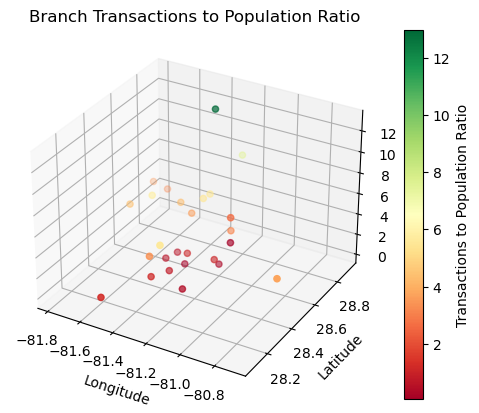

In [27]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates and ratio
x = final_df['Longitude'].astype(float)  # Longitude
y = final_df['Latitude'].astype(float)   # Latitude
z = final_df['Transactions_to_Population_Ratio']  # Transactions to population ratio

# Scatter plot
scatter = ax.scatter(x, y, z, c=z, cmap='RdYlGn', marker='o')

# Add color bar which maps values to colors
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Transactions to Population Ratio')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio')

# Show the plot
plt.show()


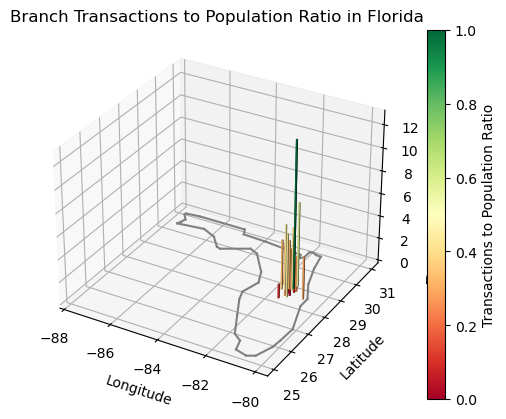

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geopandas as gpd
import numpy as np

# Convert 'Latitude' and 'Longitude' to numeric, handling non-numeric values
final_df['Latitude'] = pd.to_numeric(final_df['Latitude'], errors='coerce')
final_df['Longitude'] = pd.to_numeric(final_df['Longitude'], errors='coerce')


# Load the US states shapefile
states = gpd.read_file('Florida_shape/ne_110m_admin_1_states_provinces.shp')
florida = states[states['name'] == 'Florida']

# Extract the boundary coordinates of Florida
florida_boundary = florida.geometry.values[0].exterior.coords.xy
florida_x = list(florida_boundary[0])
florida_y = list(florida_boundary[1])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the shape of Florida
for i in range(len(florida_x) - 1):
    ax.plot([florida_x[i], florida_x[i+1]], [florida_y[i], florida_y[i+1]], [0, 0], color='gray')

# Extract coordinates and ratio from final_df
x = final_df['Longitude'].astype(float)  # Longitude
y = final_df['Latitude'].astype(float)   # Latitude
z = final_df['Transactions_to_Population_Ratio']  # Transactions to population ratio

# Normalize the z values for color mapping
z_normalized = (z - z.min()) / (z.max() - z.min())

# Plot pillars for branches
for i in range(len(x)):
    ax.bar3d(x[i], y[i], 0, 0.05, 0.05, z[i], color=plt.cm.RdYlGn(z_normalized[i]))

# Add color bar (optional)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlGn'), ax=ax)
cbar.set_label('Transactions to Population Ratio')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio in Florida')

# Show the plot
plt.show()


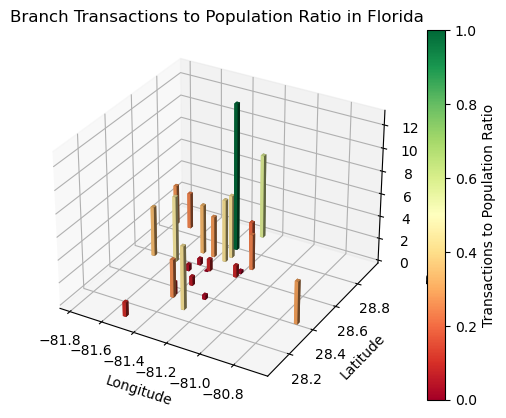

Address: 1000 Primera Blvd, Lake Mary, FL 32746, Transactions to Population Ratio: 12.97
Address: 920 Saxon Blvd, Orange City, FL 32763, Transactions to Population Ratio: 7.43
Address: 950 9th St, Winter Garden, FL 34787, Transactions to Population Ratio: 5.82
Address: 3335 13th St, Saint Cloud, FL 34769, Transactions to Population Ratio: 5.60
Address: 901 E State Road 434, Longwood, FL 32750, Transactions to Population Ratio: 5.57
Address: 215 Oxford Rd, Fern Park, FL 32730, Transactions to Population Ratio: 5.52
Address: 2390 E Highway 50, Clermont, FL 34711, Transactions to Population Ratio: 4.40
Address: 847 S Orange Blossom Trail, Apopka, FL 32703, Transactions to Population Ratio: 4.33
Address: 1380 N Courtenay Pkwy, Merritt Island, FL 32953, Transactions to Population Ratio: 3.77
Address: 855 S State Road 434, Forest City, FL 32714, Transactions to Population Ratio: 3.61
Address: 8040 US Highway 441, Leesburg, FL 34788, Transactions to Population Ratio: 3.52
Address: 708 E Vine 

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates and ratio from final_df
x = final_df['Longitude'].astype(float)  # Longitude
y = final_df['Latitude'].astype(float)   # Latitude
z = final_df['Transactions_to_Population_Ratio']  # Transactions to population ratio

# Normalize the z values for color mapping
z_normalized = (z - z.min()) / (z.max() - z.min())

# Plot pillars for branches
for i in range(len(x)):
    ax.bar3d(x[i], y[i], 0, 0.02, 0.02, z[i], color=plt.cm.RdYlGn(z_normalized[i]))

# Add color bar (optional)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlGn'), ax=ax)
cbar.set_label('Transactions to Population Ratio')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio in Florida')

# Show the plot
plt.show()

# Sorting the DataFrame by 'Transactions_to_Population_Ratio' in descending order
sorted_df = final_df.sort_values(by='Transactions_to_Population_Ratio', ascending=False)

# Loop through each row in the sorted_df and print the address and ratio
for index, row in sorted_df.iterrows():
    address = row['Address']  # Assuming 'Address' is a column in final_df
    ratio = row['Transactions_to_Population_Ratio']
    print(f"Address: {address}, Transactions to Population Ratio: {ratio:.2f}")

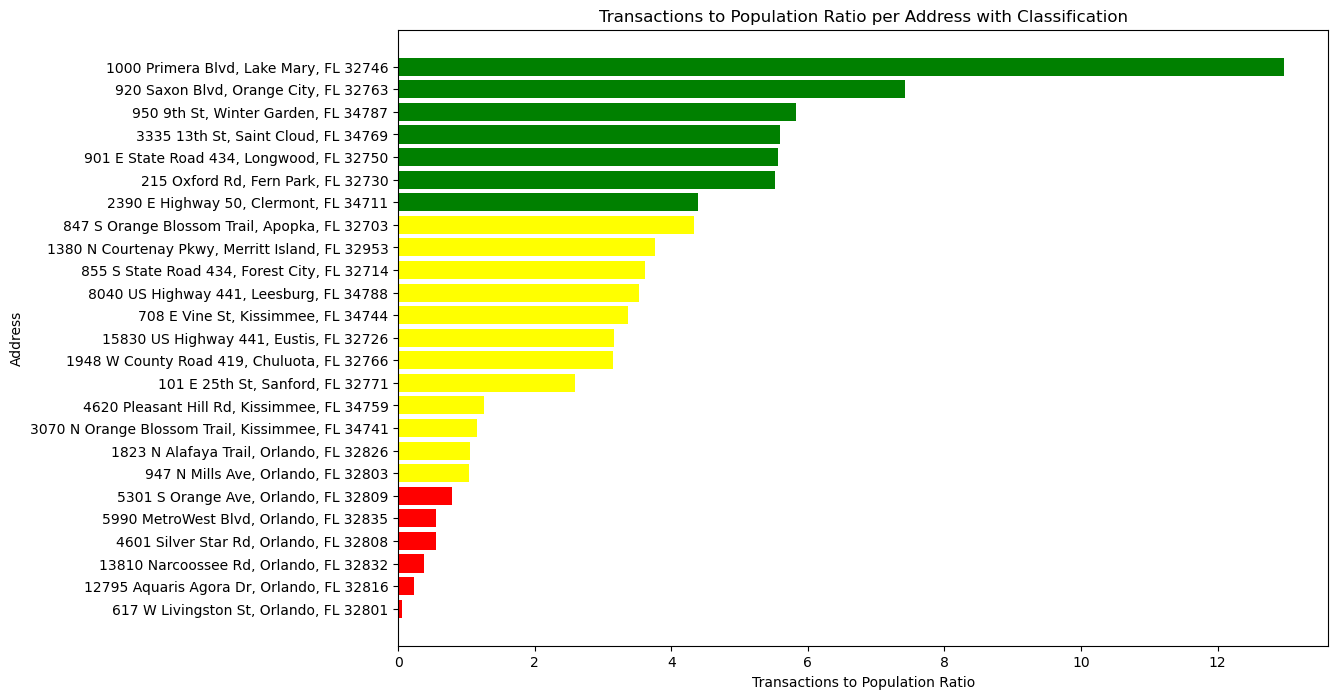

In [30]:
# Define classification thresholds
final_df = final_df.drop_duplicates(subset='Address', keep='first')
import matplotlib.pyplot as plt

# Define classification thresholds based on Transactions_to_Population_Ratio
high_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.75)  # top 25%
medium_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.25)  # bottom 25%

# Classify addresses
final_df['Classification'] = 'Low'
final_df.loc[final_df['Transactions_to_Population_Ratio'] >= medium_threshold, 'Classification'] = 'Medium'
final_df.loc[final_df['Transactions_to_Population_Ratio'] >= high_threshold, 'Classification'] = 'High'

# Sort final_df by 'Transactions_to_Population_Ratio' in descending order
sorted_final_df = final_df.sort_values(by='Transactions_to_Population_Ratio', ascending=False)

# Visualize the classified data
colors = {'Low': 'red', 'Medium': 'yellow', 'High': 'green'}
plt.figure(figsize=(12, 8))
plt.barh(sorted_final_df['Address'], sorted_final_df['Transactions_to_Population_Ratio'], color=[colors[cls] for cls in sorted_final_df['Classification']])
plt.title('Transactions to Population Ratio per Address with Classification')
plt.xlabel('Transactions to Population Ratio')
plt.ylabel('Address')
plt.gca().invert_yaxis()  # Invert the y-axis to show highest at the top
plt.show()



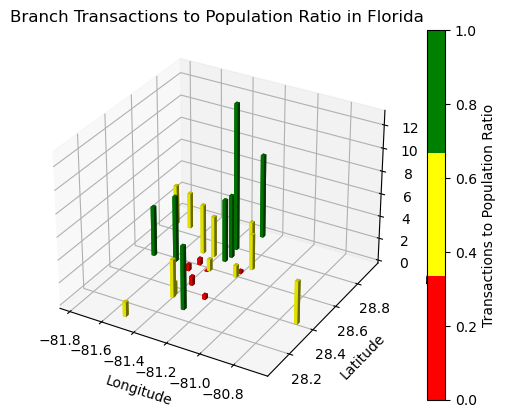

Address: 1000 Primera Blvd, Lake Mary, FL 32746, Transactions to Population Ratio: 12.97
Address: 920 Saxon Blvd, Orange City, FL 32763, Transactions to Population Ratio: 7.43
Address: 950 9th St, Winter Garden, FL 34787, Transactions to Population Ratio: 5.82
Address: 3335 13th St, Saint Cloud, FL 34769, Transactions to Population Ratio: 5.60
Address: 901 E State Road 434, Longwood, FL 32750, Transactions to Population Ratio: 5.57
Address: 215 Oxford Rd, Fern Park, FL 32730, Transactions to Population Ratio: 5.52
Address: 2390 E Highway 50, Clermont, FL 34711, Transactions to Population Ratio: 4.40
Address: 847 S Orange Blossom Trail, Apopka, FL 32703, Transactions to Population Ratio: 4.33
Address: 1380 N Courtenay Pkwy, Merritt Island, FL 32953, Transactions to Population Ratio: 3.77
Address: 855 S State Road 434, Forest City, FL 32714, Transactions to Population Ratio: 3.61
Address: 8040 US Highway 441, Leesburg, FL 34788, Transactions to Population Ratio: 3.52
Address: 708 E Vine 

In [31]:
# Define classification thresholds
high_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.75)  # top 25%
medium_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.25)  # bottom 25%

# Function to determine color based on ratio
def get_color(ratio):
    if ratio >= high_threshold:
        return 'green'  # High ratio
    elif ratio >= medium_threshold:
        return 'yellow'  # Medium ratio
    else:
        return 'red'  # Low ratio

# Apply color based on the ratio
colors = [get_color(ratio) for ratio in z]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot pillars for branches with color based on thresholds
for i in range(len(x)):
    ax.bar3d(x[i], y[i], 0, 0.02, 0.02, z[i], color=colors[i])

# Add color bar (optional)
# Create a custom color map for the color bar
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'yellow', 'green'])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax)
cbar.set_label('Transactions to Population Ratio')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio in Florida')

# Show the plot
plt.show()

# Sorting the DataFrame by 'Transactions_to_Population_Ratio' in descending order
sorted_df = final_df.sort_values(by='Transactions_to_Population_Ratio', ascending=False)

# Loop through each row in the sorted_df and print the address and ratio
for index, row in sorted_df.iterrows():
    address = row['Address']  # Assuming 'Address' is a column in final_df
    ratio = row['Transactions_to_Population_Ratio']
    print(f"Address: {address}, Transactions to Population Ratio: {ratio:.2f}")


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

high_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.75)  # top 25%
medium_threshold = final_df['Transactions_to_Population_Ratio'].quantile(0.25)  # bottom 25%

def get_category(ratio):
    if ratio >= high_threshold:
        return 'High'  # High ratio
    elif ratio >= medium_threshold:
        return 'Medium'  # Medium ratio
    else:
        return 'Low'  # Low ratio

# Apply category based on the ratio
final_df['Transaction_Category'] = final_df['Transactions_to_Population_Ratio'].apply(get_category)

# SVM Classifier Implementation
X = final_df[['Latitude', 'Longitude']]
y = final_df['Transaction_Category']  # Categorized target variable

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initializing and training the SVM classifier
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


              precision    recall  f1-score   support

        High       0.00      0.00      0.00         2
         Low       0.00      0.00      0.00         1
      Medium       0.40      1.00      0.57         2

    accuracy                           0.40         5
   macro avg       0.13      0.33      0.19         5
weighted avg       0.16      0.40      0.23         5

Accuracy: 0.4


C:\Users\natet\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natet\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natet\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\natet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\natet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\natet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\natet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

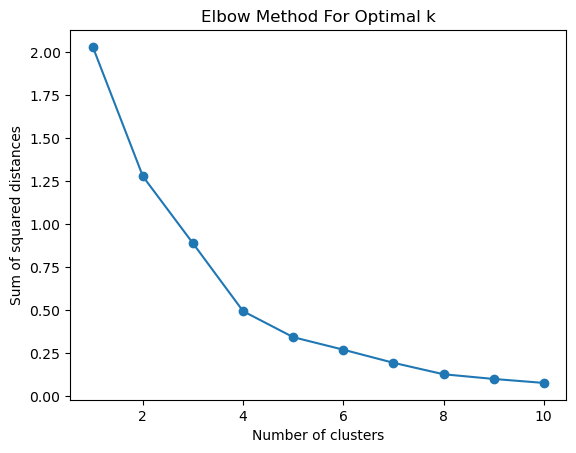

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
X = final_df[['Latitude', 'Longitude']]

# Calculating the sum of squared distances
sse = []
for k in range(1, 11):  # Trying different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    sse.append(kmeans.inertia_)

# Plotting the results
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [34]:
# Prepare new city data
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468, 'Longitude': -81.5441944},
    {'City': 'Winter Park', 'Latitude': 28.5977707, 'Longitude': -81.3510264},
    {'City': 'Maitland', 'Latitude': 28.6275253, 'Longitude': -81.3656419},
])

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(X)

# Assigning new points to clusters
new_cities_coords['Cluster'] = kmeans.predict(new_cities_coords[['Latitude', 'Longitude']])

# Estimating transaction ratio for new points
cluster_means = final_df.groupby(kmeans.labels_)['Transactions_to_Population_Ratio'].mean()
new_cities_coords['Estimated_Ratio'] = new_cities_coords['Cluster'].map(cluster_means)

# Output the estimated ratios
for index, row in new_cities_coords.iterrows():
    city = row['City']
    estimated_ratio = row['Estimated_Ratio']
    print(f"{city}: Estimated Ratio = {estimated_ratio:.4f}")


C:\Users\natet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\natet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Ocoee: Estimated Ratio = 4.2243
Winter Park: Estimated Ratio = 3.4764
Maitland: Estimated Ratio = 3.4764


C:\Users\natet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\natet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


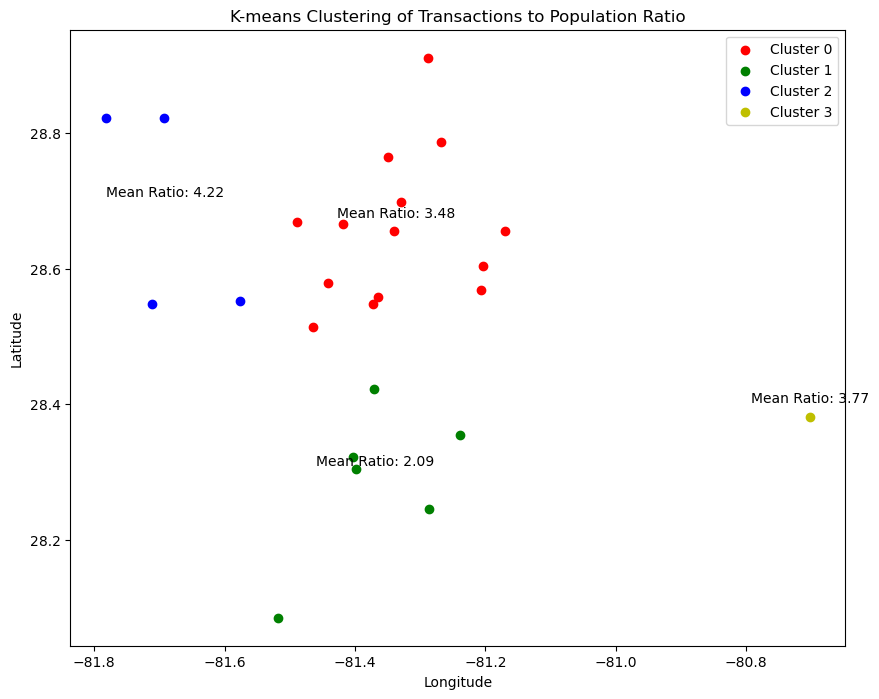

In [35]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42).fit(final_df[['Latitude', 'Longitude']])
final_df['Cluster'] = kmeans.labels_
cluster_means = final_df.groupby('Cluster')['Transactions_to_Population_Ratio'].mean().to_dict()

# Define colors for each cluster
colors = ['r', 'g', 'b', 'y']  # Add more colors if you have more clusters

# Create a 2D plot
plt.figure(figsize=(10, 8))

# Plot each data point with color based on their cluster assignment
for cluster in range(4):
    cluster_data = final_df[final_df['Cluster'] == cluster]
    plt.scatter(cluster_data['Longitude'], cluster_data['Latitude'], c=colors[cluster], label=f'Cluster {cluster}')

# Annotate the mean ratio for each cluster
for cluster, mean_ratio in cluster_means.items():
    # Get the centroid of the cluster for annotation
    centroid = kmeans.cluster_centers_[cluster]
    plt.annotate(f'Mean Ratio: {mean_ratio:.2f}', (centroid[1], centroid[0]), textcoords="offset points", xytext=(0,10), ha='center')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Transactions to Population Ratio')
plt.legend()
plt.show()


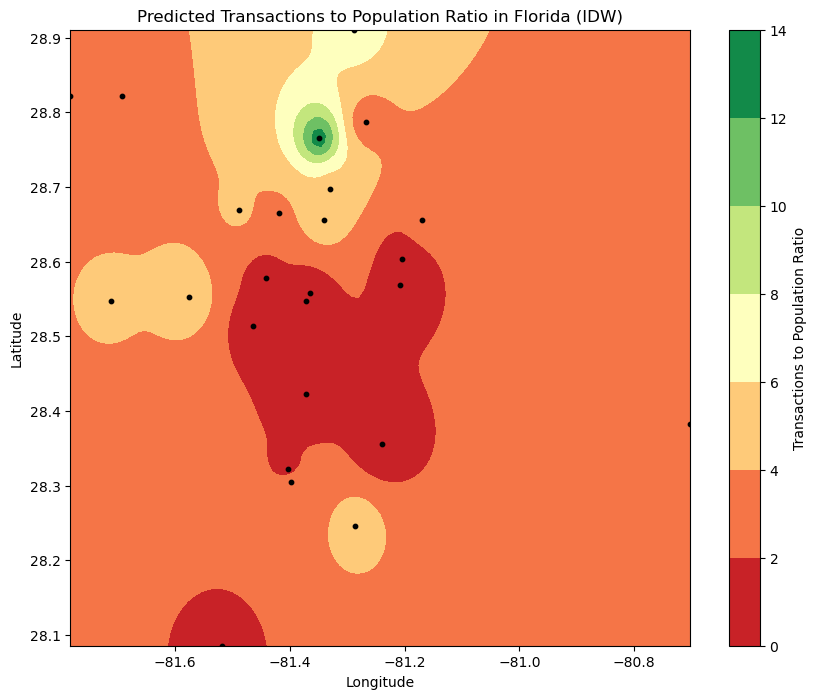

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def inverse_distance_weighting(x, y, z, xi, yi, power=2):
    # The power parameter determines the weight decay with distance
    zi = np.zeros_like(xi)
    for i in range(len(xi)):
        # Calculate the inverse distance weight for each known data point
        distances = np.sqrt((x - xi[i])**2 + (y - yi[i])**2)
        if np.any(distances == 0):
            # If the point is exactly at a known point, take that value
            zi[i] = z[np.argmin(distances)]
        else:
            weights = 1 / distances**power
            zi[i] = np.sum(weights * z) / np.sum(weights)
    return zi

# Create a grid of points where you want to estimate values
grid_x, grid_y = np.meshgrid(
    np.linspace(final_df['Longitude'].min(), final_df['Longitude'].max(), 100),
    np.linspace(final_df['Latitude'].min(), final_df['Latitude'].max(), 100)
)

# Apply IDW to the grid points using the known data points
predicted_ratios = inverse_distance_weighting(
    final_df['Longitude'].values,
    final_df['Latitude'].values,
    final_df['Transactions_to_Population_Ratio'].values,
    grid_x.ravel(),
    grid_y.ravel(),
    power=2 
)

# Plot the predicted ratios as a heatmap
plt.figure(figsize=(10, 8))
plt.contourf(grid_x, grid_y, predicted_ratios.reshape(grid_x.shape), cmap='RdYlGn')
plt.colorbar(label='Transactions to Population Ratio')
plt.scatter(final_df['Longitude'], final_df['Latitude'], c='black', s=10) # Plot the known points
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Transactions to Population Ratio in Florida (IDW)')
plt.show()


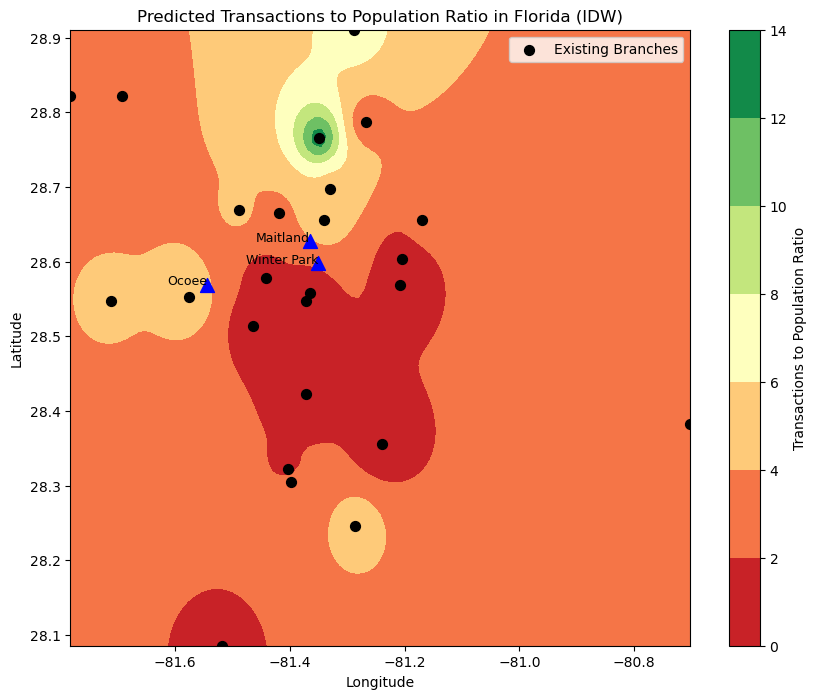

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Function for Inverse Distance Weighting
def inverse_distance_weighting(x, y, z, xi, yi, power=2):
    zi = np.zeros_like(xi)
    for i in range(len(xi)):
        distances = np.sqrt((x - xi[i])**2 + (y - yi[i])**2)
        if np.any(distances == 0):
            zi[i] = z[np.argmin(distances)]
        else:
            weights = 1 / distances**power
            zi[i] = np.sum(weights * z) / np.sum(weights)
    return zi

# Create a grid of points for the heatmap
grid_x, grid_y = np.meshgrid(
    np.linspace(final_df['Longitude'].min(), final_df['Longitude'].max(), 100),
    np.linspace(final_df['Latitude'].min(), final_df['Latitude'].max(), 100)
)

# Apply IDW to the grid points
predicted_ratios = inverse_distance_weighting(
    final_df['Longitude'].values,
    final_df['Latitude'].values,
    final_df['Transactions_to_Population_Ratio'].values,
    grid_x.ravel(),
    grid_y.ravel(),
    power=2
)

# Prepare new city data
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468, 'Longitude': -81.5441944},
    {'City': 'Winter Park', 'Latitude': 28.5977707, 'Longitude': -81.3510264},
    {'City': 'Maitland', 'Latitude': 28.6275253, 'Longitude': -81.3656419},
])

# Predict ratios using KNN
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(final_df[['Latitude', 'Longitude']], final_df['Transactions_to_Population_Ratio'])
new_cities_coords['Predicted_Ratio'] = knn.predict(new_cities_coords[['Latitude', 'Longitude']])

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.contourf(grid_x, grid_y, predicted_ratios.reshape(grid_x.shape), cmap='RdYlGn')
plt.colorbar(label='Transactions to Population Ratio')

# Plot known points (existing branches)
plt.scatter(final_df['Longitude'], final_df['Latitude'], c='black', s=50, label='Existing Branches')

# Plot new city points with labels
for i, row in new_cities_coords.iterrows():
    plt.scatter(row['Longitude'], row['Latitude'], c='blue', s=100, marker='^')
    plt.text(row['Longitude'], row['Latitude'], row['City'], fontsize=9, ha='right')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Transactions to Population Ratio in Florida (IDW)')
plt.legend()
plt.show()


In [38]:
import requests

def get_coordinates(city_name):
    formatted_name = city_name.replace(' ', '+') + ',+Florida'
    url = f"https://nominatim.openstreetmap.org/search?q={formatted_name}&format=json"
    response = requests.get(url)
    data = response.json()
    if data:
        latitude = data[0]['lat']
        longitude = data[0]['lon']
        return latitude, longitude
    else:
        return 'No data', 'No data'

cities_for_testing = ['Ocoee' ,'Winter Park', 'Maitland']
for city in cities_for_testing:
    latitude, longitude = get_coordinates(city)
    print(f"The coordinates for {city} City are Latitude: {latitude} and Longitude: {longitude}")



The coordinates for Ocoee City are Latitude: 28.5694468 and Longitude: -81.5441944
The coordinates for Winter Park City are Latitude: 28.5977707 and Longitude: -81.3510264
The coordinates for Maitland City are Latitude: 28.6275253 and Longitude: -81.3656419


In [39]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data into features and target variable
X = final_df[['Latitude', 'Longitude']]
y = final_df['Transactions_to_Population_Ratio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the KNN model
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)

# Predict the ratios for the test data
y_pred = knn.predict(X_test)

# Calculate the Mean Squared Error and R-squared values
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 15.698379407155125
R-squared: 0.14536996404143587


In [40]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

X_train = final_df[['Latitude', 'Longitude']]
y_train = final_df['Transactions_to_Population_Ratio']

# Initialize and train the KNN model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# New cities coordinates as DataFrame with column names matching X_train
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468, 'Longitude': -81.5441944}, # Orange
    {'City': 'Winter Springs', 'Latitude': 28.6987064, 'Longitude': -81.3054759}, # Seminole
    {'City': 'Groveland', 'Latitude': 28.5602149, 'Longitude': -81.8561226}, # Lake
    {'City': 'Deltona', 'Latitude': 28.9005446, 'Longitude': -81.2636738}, # Volusia
    {'City': 'Lakeland', 'Latitude': 28.0394654, 'Longitude': -81.9498042}, # Polk
    {'City': 'Palm Bay', 'Latitude': 27.9946969, 'Longitude': -80.6366144} # Brevard
])

# Predict the ratio for new cities
new_cities_coords['Predicted_Ratio'] = knn.predict(new_cities_coords[['Latitude', 'Longitude']])

# Define thresholds for classification
thresholds = {'Low': 0.25, 'Medium': 0.5, 'High': 0.75}

# Classify the predicted ratios
new_cities_coords['Classification'] = [
    'High' if r >= thresholds['High'] else 'Medium' if r >= thresholds['Medium'] else 'Low'
    for r in new_cities_coords['Predicted_Ratio']
]

# Output results
for index, row in new_cities_coords.iterrows():
    city = row['City']
    ratio = row['Predicted_Ratio']
    classification = row['Classification']
    print(f"{city}: Ratio = {ratio:.4f}, Classification = {classification}")


Ocoee: Ratio = 2.9757, Classification = High
Winter Springs: Ratio = 6.0519, Classification = High
Groveland: Ratio = 4.2451, Classification = High
Deltona: Ratio = 6.8150, Classification = High
Lakeland: Ratio = 3.1977, Classification = High
Palm Bay: Ratio = 2.8325, Classification = High


In [41]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

X_train = final_df[['Latitude', 'Longitude']]
y_train = final_df['Transactions_to_Population_Ratio']

# Initialize and train the KNN model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# New cities coordinates as DataFrame with column names matching X_train
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468 , 'Longitude': -81.5441944}, # Orange
    {'City': 'Winter Park', 'Latitude': 28.5977707 , 'Longitude': -81.3510264}, # Orange
    {'City': 'Maitland', 'Latitude': 28.6275253 , 'Longitude': -81.3656419}, # Orange

])

# Predict the ratio for new cities
new_cities_coords['Predicted_Ratio'] = knn.predict(new_cities_coords[['Latitude', 'Longitude']])

# Define thresholds for classification
thresholds = {'Low': 0.25, 'Medium': 0.5, 'High': 0.75}

# Classify the predicted ratios
new_cities_coords['Classification'] = [
    'High' if r >= thresholds['High'] else 'Medium' if r >= thresholds['Medium'] else 'Low'
    for r in new_cities_coords['Predicted_Ratio']
]

# Output results
for index, row in new_cities_coords.iterrows():
    city = row['City']
    ratio = row['Predicted_Ratio']
    classification = row['Classification']
    print(f"{city}: Ratio = {ratio:.4f}, Classification = {classification}")

Ocoee: Ratio = 2.9757, Classification = High
Winter Park: Ratio = 2.1582, Classification = High
Maitland: Ratio = 3.1599, Classification = High


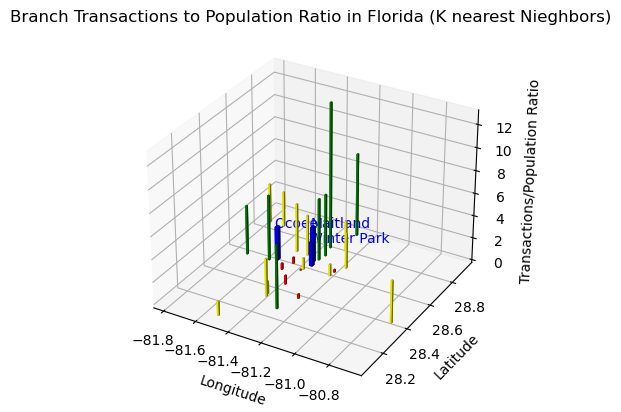

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a function to categorize the ratio
def get_color(ratio):
    if ratio >= high_threshold:
        return 'green'
    elif ratio >= medium_threshold:
        return 'yellow'
    else:
        return 'red'

# Add new cities coordinates
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468 , 'Longitude': -81.5441944, 'Ratio': 2.9757}, # Orange
    {'City': 'Winter Park', 'Latitude': 28.5977707 , 'Longitude': -81.3510264, 'Ratio': 2.1582}, # Orange
    {'City': 'Maitland', 'Latitude': 28.6275253 , 'Longitude': -81.3656419, 'Ratio': 3.1599}, # Orange
], index=['Ocoee', 'Winter Park', 'Maitland'])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot existing branches
for i in range(len(final_df)):
    x = final_df['Longitude'].iloc[i]
    y = final_df['Latitude'].iloc[i]
    z = final_df['Transactions_to_Population_Ratio'].iloc[i]
    color = get_color(z)
    ax.bar3d(x, y, 0, 0.01, 0.01, z, color=color)

# Plot new cities as blue pillars
for city, row in new_cities_coords.iterrows():
    x, y, z = row['Longitude'], row['Latitude'], row['Ratio']
    ax.bar3d(x, y, 0, 0.02, 0.02, z, color='blue')  # Blue pillars for new cities
    ax.text(x, y, z, city, color='blue')  # Label for new city

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio in Florida (K nearest Nieghbors)')

# Show the plot
plt.show()


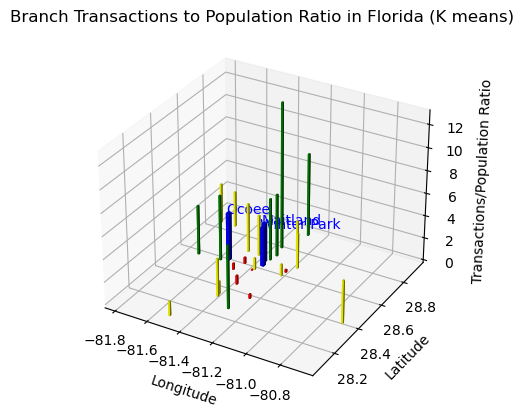

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a function to categorize the ratio
def get_color(ratio):
    if ratio >= high_threshold:
        return 'green'
    elif ratio >= medium_threshold:
        return 'yellow'
    else:
        return 'red'

# Add new cities coordinates
new_cities_coords = pd.DataFrame([
    {'City': 'Ocoee', 'Latitude': 28.5694468 , 'Longitude': -81.5441944, 'Ratio': 4.2243}, # Orange
    {'City': 'Winter Park', 'Latitude': 28.5977707 , 'Longitude': -81.3510264, 'Ratio': 3.4764}, # Orange
    {'City': 'Maitland', 'Latitude': 28.6275253 , 'Longitude': -81.3656419, 'Ratio': 3.4764}, # Orange
], index=['Ocoee', 'Winter Park', 'Maitland'])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot existing branches
for i in range(len(final_df)):
    x = final_df['Longitude'].iloc[i]
    y = final_df['Latitude'].iloc[i]
    z = final_df['Transactions_to_Population_Ratio'].iloc[i]
    color = get_color(z)
    ax.bar3d(x, y, 0, 0.01, 0.01, z, color=color)

# Plot new cities as blue pillars
for city, row in new_cities_coords.iterrows():
    x, y, z = row['Longitude'], row['Latitude'], row['Ratio']
    ax.bar3d(x, y, 0, 0.02, 0.02, z, color='blue')  # Blue pillars for new cities
    ax.text(x, y, z, city, color='blue')  # Label for new city

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Transactions/Population Ratio')
ax.set_title('Branch Transactions to Population Ratio in Florida (K means)')

# Show the plot
plt.show()